In [13]:
import kagglehub

path = kagglehub.dataset_download("xixuhu/office31")

print("Path to files: ", path)

Path to files:  /kaggle/input/office31


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import time

import torch
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Function Declarations

In [15]:
# Load the ResNet50 model pre-trained on ImageNet
model = models.resnet50(pretrained=True)

In [16]:
def create_loaders(source_path, target_path, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    source_dataset = datasets.ImageFolder(source_path, transform)
    target_dataset = datasets.ImageFolder(target_path, transform)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    return source_loader, target_loader

In [17]:
def performance_drop(model, loader, device):
    correct = 0
    total = 0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # ResNet50 directly returns logits
            _, predicted = outputs.max(1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [18]:
# Load pre-trained ResNet50 model and remove the final classification layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  # Replace the final FC layer with an identity function
resnet = resnet.to(device)
resnet.eval()

# Function to extract features from a DataLoader
def extract_features(model, loader, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            feats = model(images)
            features.append(feats.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [19]:
# Function to visualize t-SNE
def visualize_tsne(source_loader, target_loader, model, device, source_name, target_name):
    # Extract features for source and target domains
    source_features, source_labels = extract_features(model, source_loader, device)
    target_features, target_labels = extract_features(model, target_loader, device)

    # Combine features and assign domain labels
    combined_features = np.concatenate([source_features, target_features], axis=0)
    domain_labels = np.array([0] * len(source_features) + [1] * len(target_features))  # 0 for source, 1 for target

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(combined_features)

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[domain_labels == 0, 0], tsne_results[domain_labels == 0, 1],
                c='blue', label=f'Source: {source_name}', alpha=0.6)
    plt.scatter(tsne_results[domain_labels == 1, 0], tsne_results[domain_labels == 1, 1],
                c='red', label=f'Target: {target_name}', alpha=0.6)
    plt.title(f"t-SNE Visualization: {source_name} → {target_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Define domain paths
domains = {
    "A": '/kaggle/input/office31/Office-31/amazon',
    "W": '/kaggle/input/office31/Office-31/webcam',
    "D": '/kaggle/input/office31/Office-31/dslr'
}

# Specify all domain adaptation tasks
tasks = [
    ("A", "D"),
    ("A", "W"),
    ("D", "A"),
    ("D", "W"),
    ("W", "A"),
    ("W", "D")
]

# # Visualize t-SNE for each task
# for source, target in tasks:
#     source_loader, target_loader = create_loaders(domains[source], domains[target])
#     visualize_tsne(
#         source_loader=source_loader,
#         target_loader=target_loader,
#         model=resnet,
#         device=device,
#         source_name=source,
#         target_name=target
#     )

# Source = Amazon

In [20]:
# Parameters
data_dir = "/kaggle/input/office31/Office-31/amazon"  # Path to the Amazon domain of Office-31 dataset
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = 31  # Office-31 has 31 classes

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations: typical augmentations or normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Replace the final FC layer to match the number of classes in Office-31
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s")

print("Finetuning completed.")

Epoch [1/10], Loss: 2.4034, Acc: 35.11%, Time: 17.33s
Epoch [2/10], Loss: 1.6657, Acc: 54.14%, Time: 15.94s
Epoch [3/10], Loss: 1.4386, Acc: 59.39%, Time: 15.90s
Epoch [4/10], Loss: 1.1658, Acc: 66.92%, Time: 15.93s
Epoch [5/10], Loss: 1.0157, Acc: 71.53%, Time: 15.94s
Epoch [6/10], Loss: 0.8739, Acc: 75.33%, Time: 15.92s
Epoch [7/10], Loss: 0.7928, Acc: 77.32%, Time: 15.95s
Epoch [8/10], Loss: 0.6761, Acc: 79.16%, Time: 16.02s
Epoch [9/10], Loss: 0.5778, Acc: 83.07%, Time: 15.96s
Epoch [10/10], Loss: 0.5293, Acc: 84.52%, Time: 15.91s
Finetuning completed.


# A -> D

In [21]:
# Evaluate performance
source_path = '/kaggle/input/office31/Office-31/amazon'
target_path = '/kaggle/input/office31/Office-31/dslr'

source_loader, target_loader = create_loaders(source_path, target_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

plotting = []
my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 70.50%
Target Accuracy: 26.91%
Performance Drop: 61.83%


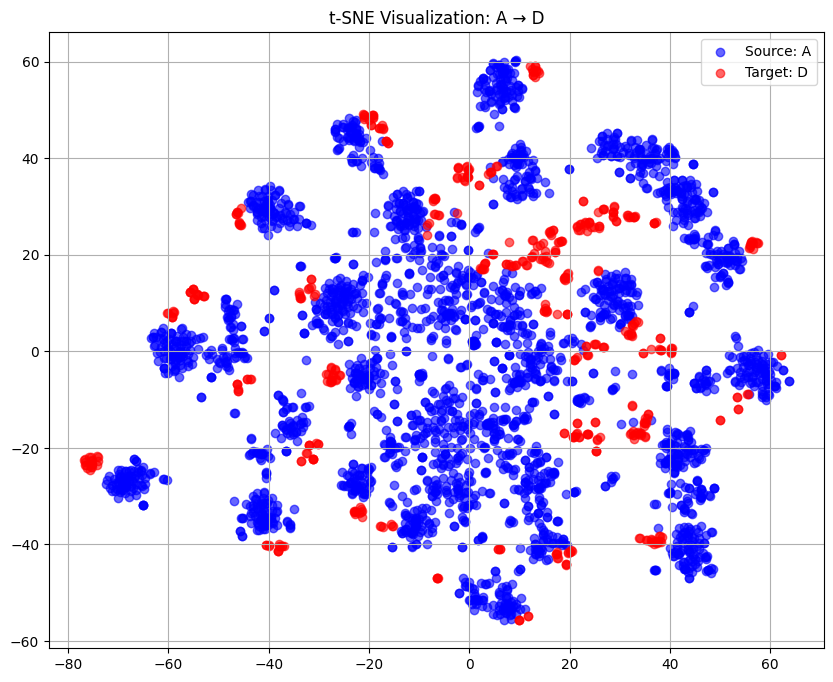

In [23]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="A",
        target_name="D"
    )

# A -> W

In [24]:
target_path = '/kaggle/input/office31/Office-31/webcam'

source_loader, target_loader = create_loaders(source_path, target_path)

# Evaluate performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")


my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 71.25%
Target Accuracy: 22.39%
Performance Drop: 68.57%


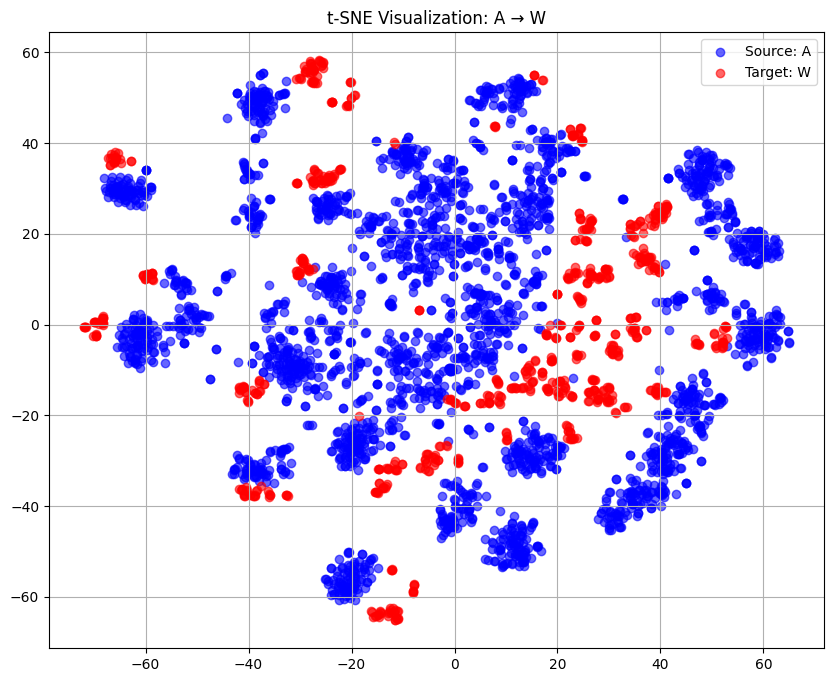

In [25]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="A",
        target_name="W"
    )

# Source = DSLR

In [26]:
model = models.resnet50(pretrained=True)

data_dir = "/kaggle/input/office31/Office-31/dslr"  # Path to the Amazon domain of Office-31 dataset
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = 31  # Office-31 has 31 classes

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations: typical augmentations or normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


# Replace the final FC layer to match the number of classes in Office-31
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s")

print("Finetuning completed.")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 2.2793, Acc: 41.97%, Time: 3.79s
Epoch [2/10], Loss: 1.1567, Acc: 68.27%, Time: 3.58s
Epoch [3/10], Loss: 0.5637, Acc: 83.73%, Time: 3.64s
Epoch [4/10], Loss: 0.4317, Acc: 87.95%, Time: 3.69s
Epoch [5/10], Loss: 0.3374, Acc: 89.96%, Time: 3.61s
Epoch [6/10], Loss: 0.2541, Acc: 93.78%, Time: 4.27s
Epoch [7/10], Loss: 0.2357, Acc: 93.57%, Time: 3.67s
Epoch [8/10], Loss: 0.2239, Acc: 94.38%, Time: 3.60s
Epoch [9/10], Loss: 0.1979, Acc: 93.37%, Time: 3.74s
Epoch [10/10], Loss: 0.1796, Acc: 94.38%, Time: 3.57s
Finetuning completed.


# D -> A

In [27]:
# Evaluate performance
source_path = '/kaggle/input/office31/Office-31/dslr'
target_path = '/kaggle/input/office31/Office-31/amazon'

source_loader, target_loader = create_loaders(source_path, target_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 77.31%
Target Accuracy: 13.49%
Performance Drop: 82.55%


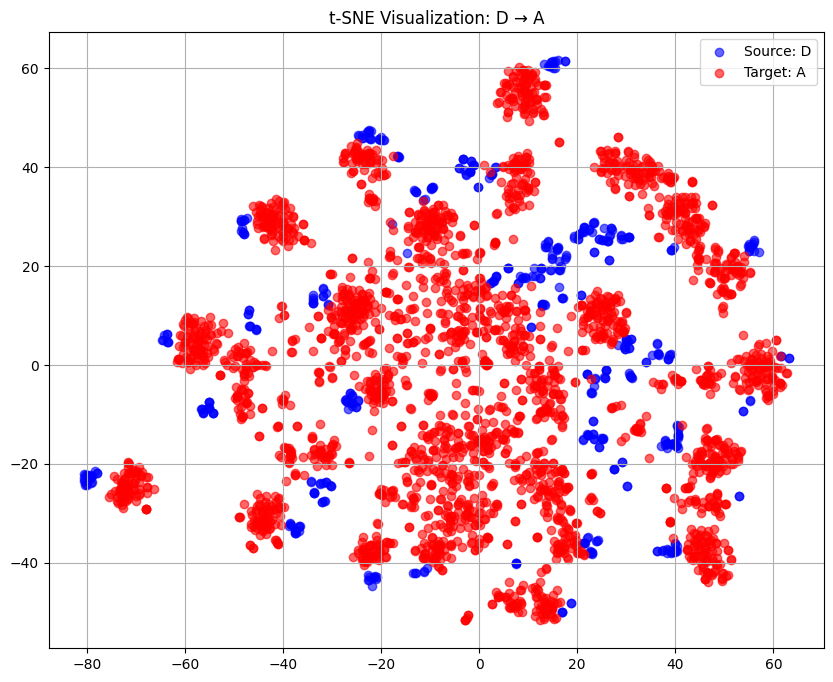

In [28]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="D",
        target_name="A"
    )

# D -> W

In [29]:
# Evaluate performance
source_path = '/kaggle/input/office31/Office-31/dslr'
target_path = '/kaggle/input/office31/Office-31/webcam'

source_loader, target_loader = create_loaders(source_path, target_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 77.71%
Target Accuracy: 60.38%
Performance Drop: 22.31%


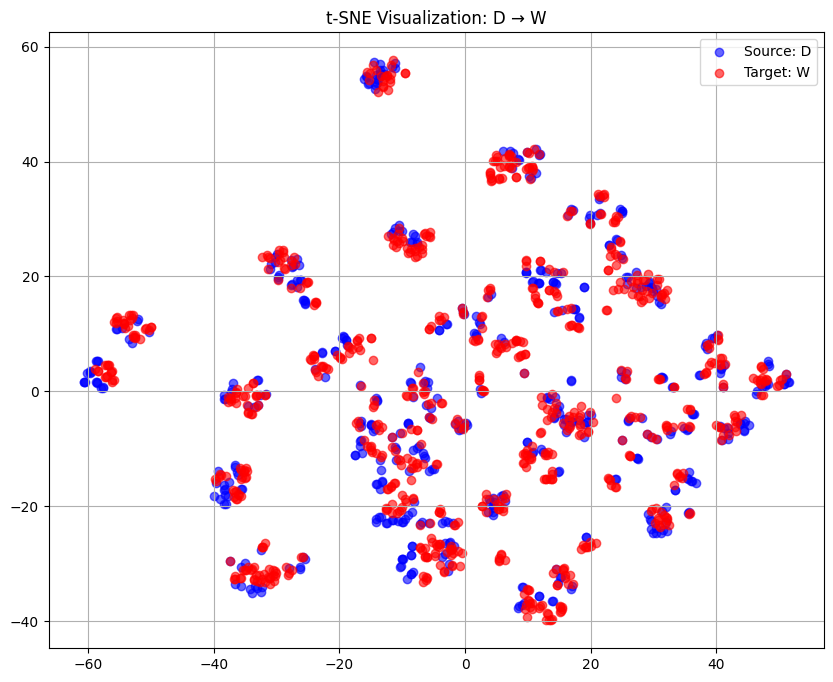

In [30]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="D",
        target_name="W"
    )

# Source = Webcam

In [31]:
model = models.resnet50(pretrained=True)

data_dir = "/kaggle/input/office31/Office-31/webcam"  # Path to the Amazon domain of Office-31 dataset
num_epochs = 10
batch_size = 32
learning_rate = 0.001
num_classes = 31  # Office-31 has 31 classes

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations: typical augmentations or normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


# Replace the final FC layer to match the number of classes in Office-31
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprop & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s")

print("Finetuning completed.")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.8887, Acc: 47.04%, Time: 4.87s
Epoch [2/10], Loss: 0.8384, Acc: 74.21%, Time: 4.85s
Epoch [3/10], Loss: 0.5232, Acc: 83.40%, Time: 4.91s
Epoch [4/10], Loss: 0.6156, Acc: 82.01%, Time: 4.83s
Epoch [5/10], Loss: 0.4339, Acc: 87.42%, Time: 4.88s
Epoch [6/10], Loss: 0.3177, Acc: 89.69%, Time: 4.88s
Epoch [7/10], Loss: 0.2072, Acc: 93.21%, Time: 4.85s
Epoch [8/10], Loss: 0.1225, Acc: 95.72%, Time: 4.85s
Epoch [9/10], Loss: 0.1266, Acc: 95.97%, Time: 4.87s
Epoch [10/10], Loss: 0.1104, Acc: 96.73%, Time: 4.86s
Finetuning completed.


# W -> A

In [32]:
# Evaluate performance
source_path = '/kaggle/input/office31/Office-31/webcam'
target_path = '/kaggle/input/office31/Office-31/amazon'

source_loader, target_loader = create_loaders(source_path, target_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 82.01%
Target Accuracy: 10.51%
Performance Drop: 87.19%


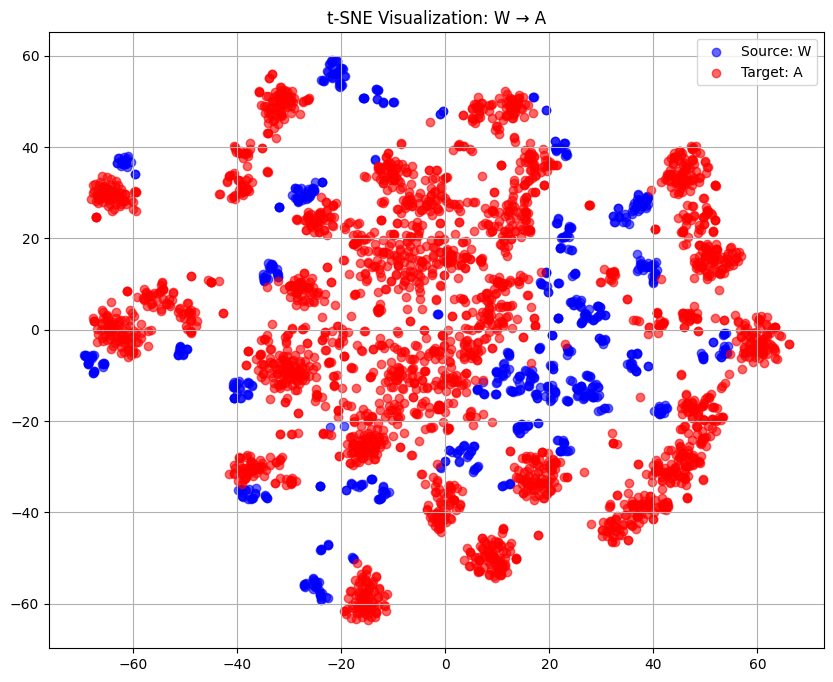

In [33]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="W",
        target_name="A"
    )

# W -> D

In [34]:
# Evaluate performance
source_path = '/kaggle/input/office31/Office-31/webcam'
target_path = '/kaggle/input/office31/Office-31/dslr'

source_loader, target_loader = create_loaders(source_path, target_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")

my_list = [source_accuracy, target_accuracy, drop]
plotting.append(my_list)

Source Accuracy: 80.88%
Target Accuracy: 51.61%
Performance Drop: 36.19%


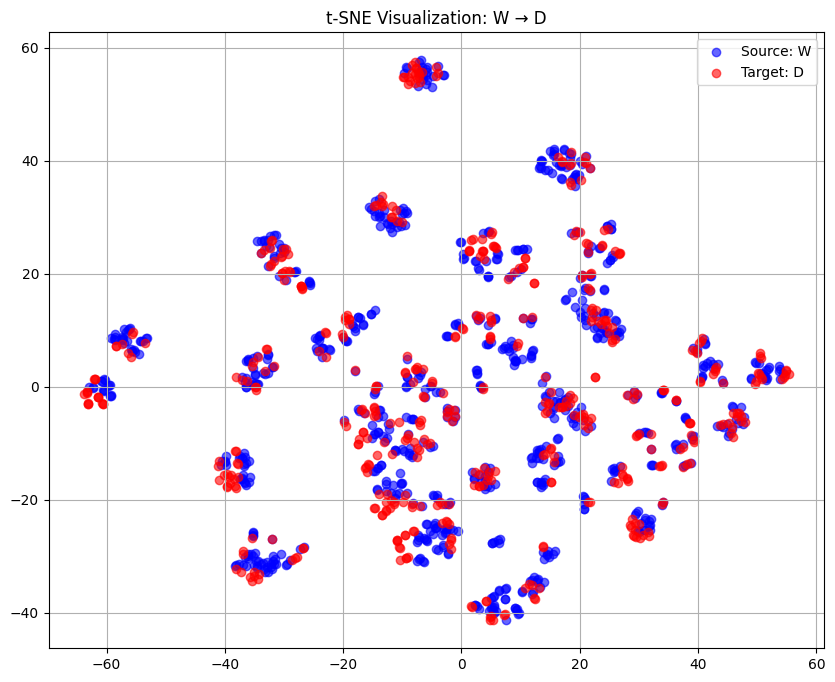

In [35]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=resnet,
        device=device,
        source_name="W",
        target_name="D"
    )

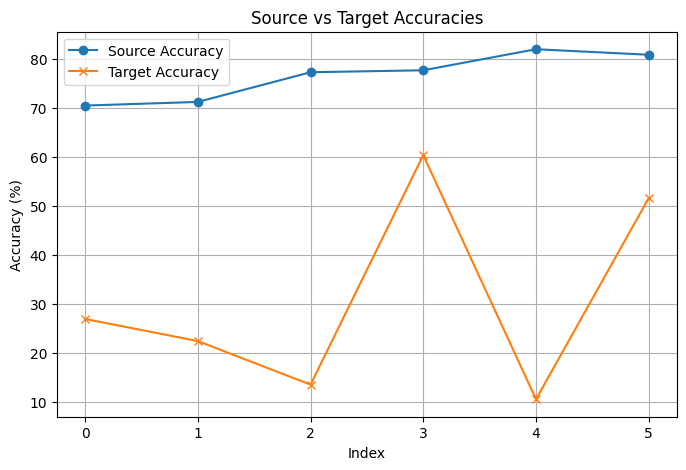

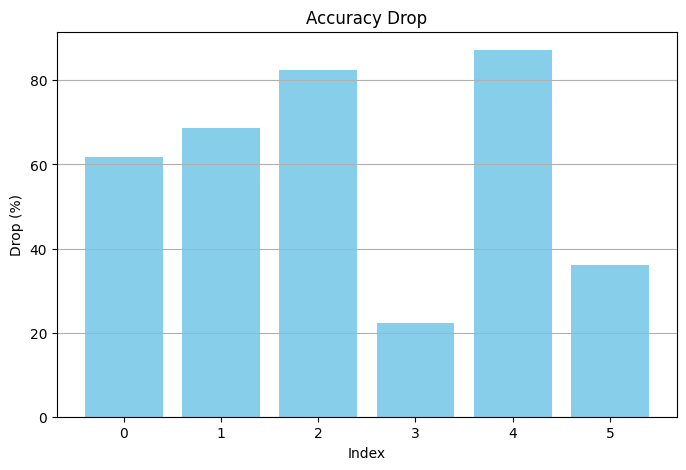

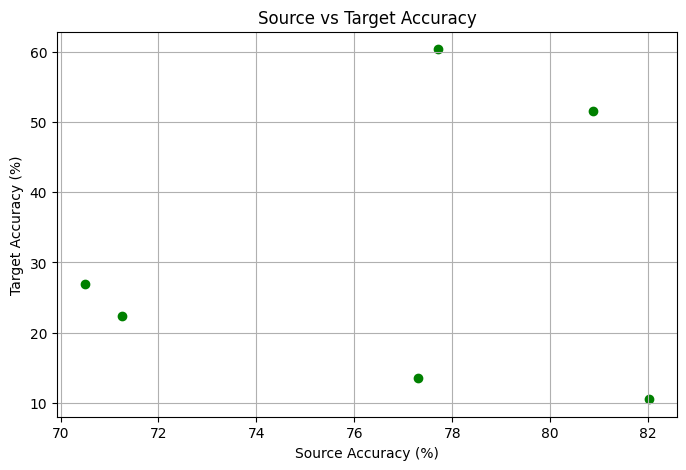

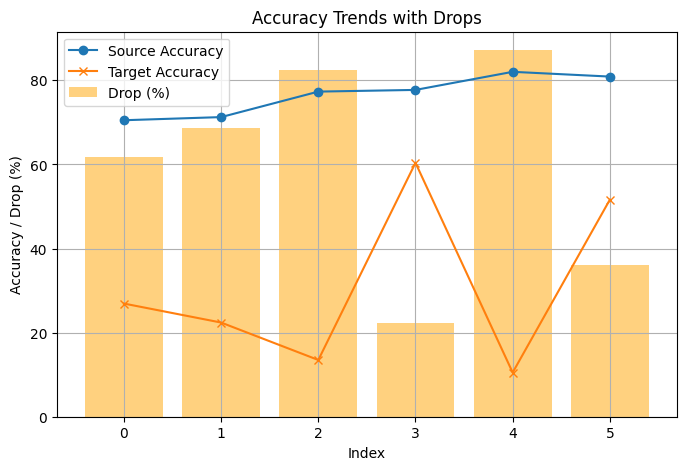

In [36]:
import matplotlib.pyplot as plt

# Extract data from the list
source_accuracies = [row[0] for row in plotting]
target_accuracies = [row[1] for row in plotting]
drops = [row[2] for row in plotting]

# 1. Line Plot for Source vs Target Accuracies
plt.figure(figsize=(8, 5))
plt.plot(source_accuracies, label="Source Accuracy", marker='o')
plt.plot(target_accuracies, label="Target Accuracy", marker='x')
plt.title("Source vs Target Accuracies")
plt.xlabel("Index")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# 2. Bar Plot for Accuracy Drop
plt.figure(figsize=(8, 5))
plt.bar(range(len(drops)), drops, color='skyblue')
plt.title("Accuracy Drop")
plt.xlabel("Index")
plt.ylabel("Drop (%)")
plt.xticks(range(len(drops)))
plt.grid(axis='y')
plt.show()

# 3. Scatter Plot of Source vs Target Accuracy
plt.figure(figsize=(8, 5))
plt.scatter(source_accuracies, target_accuracies, color='green')
plt.title("Source vs Target Accuracy")
plt.xlabel("Source Accuracy (%)")
plt.ylabel("Target Accuracy (%)")
plt.grid()
plt.show()

# 4. Combined Plot for Accuracy Trends
plt.figure(figsize=(8, 5))
plt.plot(source_accuracies, label="Source Accuracy", marker='o')
plt.plot(target_accuracies, label="Target Accuracy", marker='x')
plt.bar(range(len(drops)), drops, alpha=0.5, label="Drop (%)", color='orange')
plt.title("Accuracy Trends with Drops")
plt.xlabel("Index")
plt.ylabel("Accuracy / Drop (%)")
plt.legend()
plt.grid()
plt.show()


In [37]:
!pip install ace_tools

In [38]:
import pandas as pd

# Extract target accuracies
tasks = ["A → D", "A → W", "D → A", "D → W", "W → A", "W → D"]
target_accuracies = [row[1] for row in plotting]

# Calculate average accuracy
average_accuracy = sum(target_accuracies) / len(target_accuracies)

# Construct table
data = {
    "Method": ["ResNet-50"],
    "A → D": [target_accuracies[0]],
    "A → W": [target_accuracies[1]],
    "D → A": [target_accuracies[2]],
    "D → W": [target_accuracies[3]],
    "W → A": [target_accuracies[4]],
    "W → D": [target_accuracies[5]],
    "Avg.": [average_accuracy]
}

# Create DataFrame
df = pd.DataFrame(data)

df.head()

,Method,A → D,A → W,D → A,D → W,W → A,W → D,Avg.
0,ResNet-50,26.907631,22.389937,13.489528,60.377358,10.507632,51.606426,30.879752


In [39]:
import torch
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained ResNet50 model and remove the final classification layer
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  # Replace the final FC layer with an identity function
resnet = resnet.to(device)
resnet.eval()

# Function to extract features from a DataLoader
def extract_features(model, loader, device):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            feats = model(images)
            features.append(feats.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Extract features for source and target domains
source_features, source_labels = extract_features(resnet, source_loader, device)
target_features, target_labels = extract_features(resnet, target_loader, device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


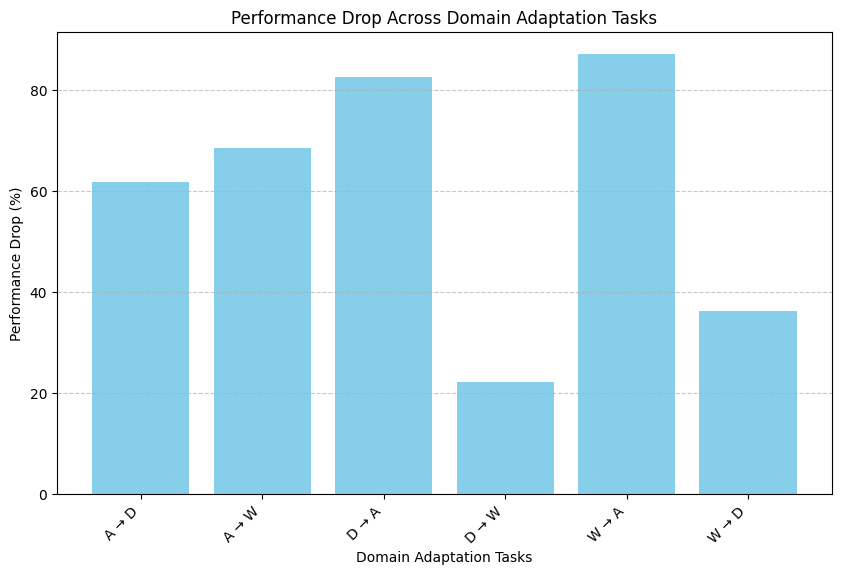

In [40]:
# Define task labels
tasks = ["A → D", "A → W", "D → A", "D → W", "W → A", "W → D"]

# Extract performance drop values
performance_drops = [row[2] for row in plotting]

# Plot performance drop
plt.figure(figsize=(10, 6))
plt.bar(tasks, performance_drops, color='skyblue')
plt.title("Performance Drop Across Domain Adaptation Tasks")
plt.xlabel("Domain Adaptation Tasks")
plt.ylabel("Performance Drop (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Digits Dataset

In [41]:
model = models.resnet50(pretrained=True)

In [42]:
from torch.utils.data import Subset
import random

def load_digits_dataset(source_domain, target_domain, batch_size=32, subset_size=None):
    """Loads custom digits datasets (MNIST, USPS, SVHN) for source and target domains with optional subset."""
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for 3 channels
        ]),
        'val': transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for 3 channels
        ])
    }

    dataset_mapping = {
        'MNIST': lambda train: datasets.MNIST(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'USPS': lambda train: datasets.USPS(root="./data", train=train, download=True, transform=data_transforms['train' if train else 'val']),
        'SVHN': lambda train: datasets.SVHN(root="./data", split='train' if train else 'test', download=True, transform=data_transforms['train' if train else 'val'])
    }

    if source_domain not in dataset_mapping or target_domain not in dataset_mapping:
        raise ValueError("Invalid domain. Supported domains are: MNIST, USPS, SVHN")

    source_dataset = dataset_mapping[source_domain](train=True)
    target_dataset = dataset_mapping[target_domain](train=False)

    # Apply subset if specified
    if subset_size:
        source_indices = random.sample(range(len(source_dataset)), subset_size)
        target_indices = random.sample(range(len(target_dataset)), subset_size)
        source_dataset = Subset(source_dataset, source_indices)
        target_dataset = Subset(target_dataset, target_indices)

    source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return source_loader, target_loader

In [52]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

def finetune(model, source_domain, target_domain, num_epochs=10, batch_size=32, learning_rate=0.001, subset_size=None):
    """
    Fine-tune a model for a given source and target domain.

    Args:
        model (nn.Module): The model to fine-tune.
        source_domain (str): Name of the source domain (e.g., 'MNIST').
        target_domain (str): Name of the target domain (e.g., 'SVHN').
        num_epochs (int): Number of epochs for training.
        batch_size (int): Batch size for DataLoader.
        learning_rate (float): Learning rate for the optimizer.
        subset_size (int, optional): Size of the subset for faster training.

    Returns:
        nn.Module: The fine-tuned model.
    """
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data transformations
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    source_loader, target_loader = load_digits_dataset(source_domain, target_domain, batch_size=batch_size, subset_size=subset_size)

    # Modify the model's final layer
    in_features = model.fc.in_features
    num_classes = 10  # Assuming 10 classes for the task
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for images, labels in source_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {epoch_time:.2f}s")

    print("Finetuning completed.")
    return model, source_loader, target_loader

# Source = MNIST

In [77]:
model = models.resnet50(pretrained=True)
model, source_loader, target_loader = finetune(model, source_domain='MNIST', target_domain='SVHN', num_epochs=10, batch_size=32, subset_size=1000)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: ./data/test_32x32.mat
Epoch [1/10], Loss: 1.2917, Acc: 59.10%, Time: 1.66s
Epoch [2/10], Loss: 0.6094, Acc: 83.40%, Time: 1.44s
Epoch [3/10], Loss: 0.2952, Acc: 92.80%, Time: 1.42s
Epoch [4/10], Loss: 0.2804, Acc: 92.60%, Time: 1.44s
Epoch [5/10], Loss: 0.2481, Acc: 93.70%, Time: 1.50s
Epoch [6/10], Loss: 0.1918, Acc: 94.80%, Time: 1.41s
Epoch [7/10], Loss: 0.0999, Acc: 97.20%, Time: 1.41s
Epoch [8/10], Loss: 0.0864, Acc: 98.00%, Time: 1.49s
Epoch [9/10], Loss: 0.1649, Acc: 96.80%, Time: 1.48s
Epoch [10/10], Loss: 0.1814, Acc: 94.80%, Time: 1.41s
Finetuning completed.


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops = []
performance_drops.append(drop)

Source Accuracy: 99.20%
Target Accuracy: 24.50%
Performance Drop: 75.30%


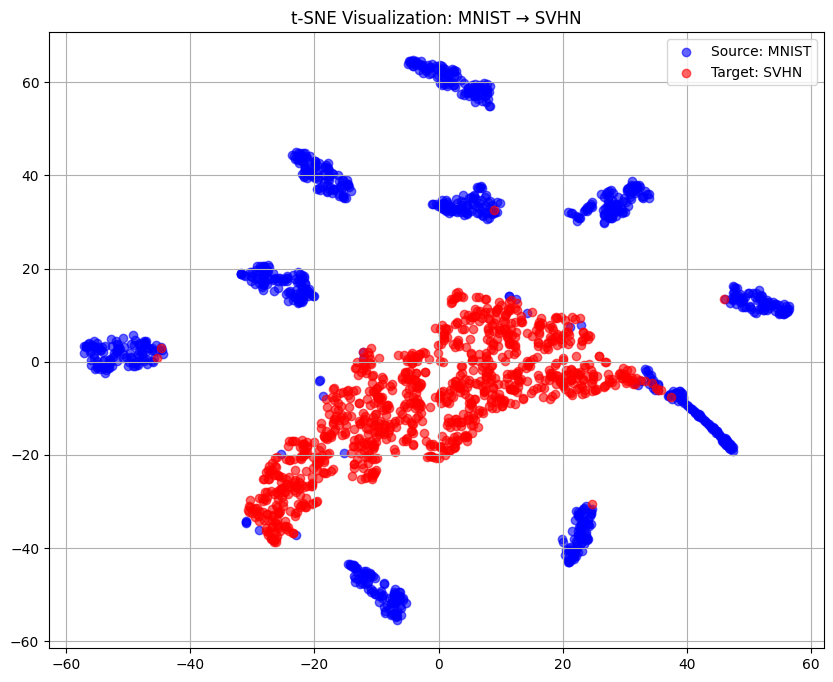

In [79]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="MNIST",
        target_name="SVHN"
    )

In [80]:
source_loader, target_loader = load_digits_dataset('MNIST', 'USPS', batch_size=32, subset_size=1000)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops.append(drop)

Source Accuracy: 94.80%
Target Accuracy: 53.00%
Performance Drop: 44.09%


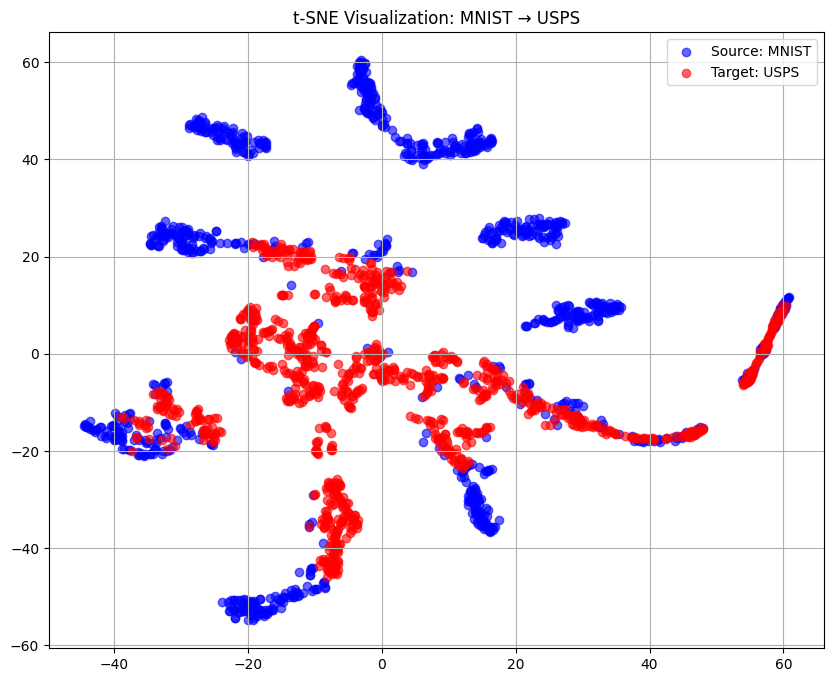

In [81]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="MNIST",
        target_name="USPS"
    )

# Source = SVHN

In [82]:
model = models.resnet50(pretrained=True)
model, source_loader, target_loader = finetune(model, source_domain='SVHN', target_domain='MNIST', num_epochs=10, batch_size=32, subset_size=1000)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: ./data/train_32x32.mat
Epoch [1/10], Loss: 2.3828, Acc: 24.80%, Time: 1.49s
Epoch [2/10], Loss: 1.8090, Acc: 44.10%, Time: 1.48s
Epoch [3/10], Loss: 1.1267, Acc: 63.10%, Time: 1.40s
Epoch [4/10], Loss: 0.8811, Acc: 73.00%, Time: 1.50s
Epoch [5/10], Loss: 0.9785, Acc: 71.10%, Time: 1.41s
Epoch [6/10], Loss: 0.8063, Acc: 77.20%, Time: 1.45s
Epoch [7/10], Loss: 1.1108, Acc: 67.80%, Time: 1.48s
Epoch [8/10], Loss: 0.6988, Acc: 79.10%, Time: 1.41s
Epoch [9/10], Loss: 0.4308, Acc: 86.70%, Time: 1.48s
Epoch [10/10], Loss: 0.4137, Acc: 88.10%, Time: 1.41s
Finetuning completed.


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops.append(drop)

Source Accuracy: 94.60%
Target Accuracy: 47.90%
Performance Drop: 49.37%


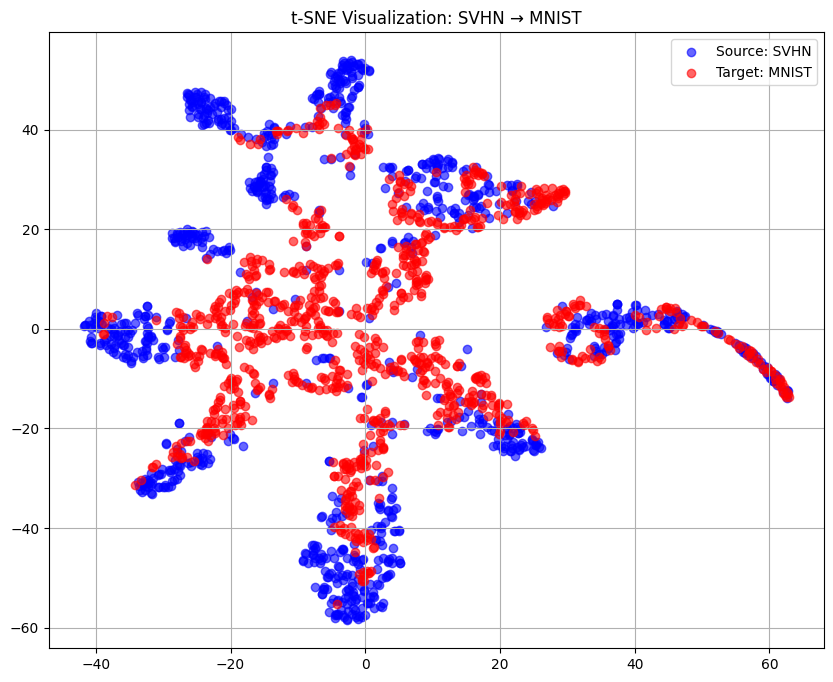

In [84]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="SVHN",
        target_name="MNIST"
    )

In [85]:
source_loader, target_loader = load_digits_dataset('SVHN', 'USPS', batch_size=32, subset_size=1000)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops.append(drop)

Using downloaded and verified file: ./data/train_32x32.mat
Source Accuracy: 76.40%
Target Accuracy: 50.40%
Performance Drop: 34.03%


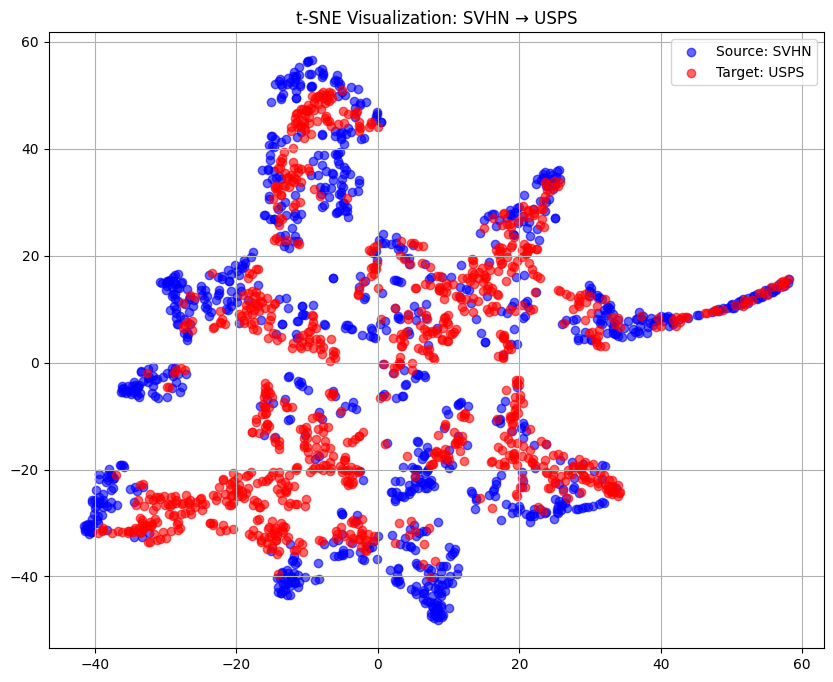

In [86]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="SVHN",
        target_name="USPS"
    )

# Source - USPS

In [87]:
model = models.resnet50(pretrained=True)
model, source_loader, target_loader = finetune(model, source_domain='USPS', target_domain='MNIST', num_epochs=10, batch_size=32, subset_size=1000)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9877, Acc: 72.20%, Time: 1.43s
Epoch [2/10], Loss: 0.4714, Acc: 88.20%, Time: 1.47s
Epoch [3/10], Loss: 0.3584, Acc: 90.50%, Time: 1.45s
Epoch [4/10], Loss: 0.3128, Acc: 94.50%, Time: 1.50s
Epoch [5/10], Loss: 0.2874, Acc: 94.70%, Time: 1.48s
Epoch [6/10], Loss: 0.1301, Acc: 97.80%, Time: 1.41s
Epoch [7/10], Loss: 0.1686, Acc: 96.90%, Time: 1.40s
Epoch [8/10], Loss: 0.0940, Acc: 97.30%, Time: 1.41s
Epoch [9/10], Loss: 0.0815, Acc: 98.70%, Time: 1.44s
Epoch [10/10], Loss: 0.2550, Acc: 95.80%, Time: 1.41s
Finetuning completed.


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops.append(drop)

Source Accuracy: 91.90%
Target Accuracy: 37.90%
Performance Drop: 58.76%


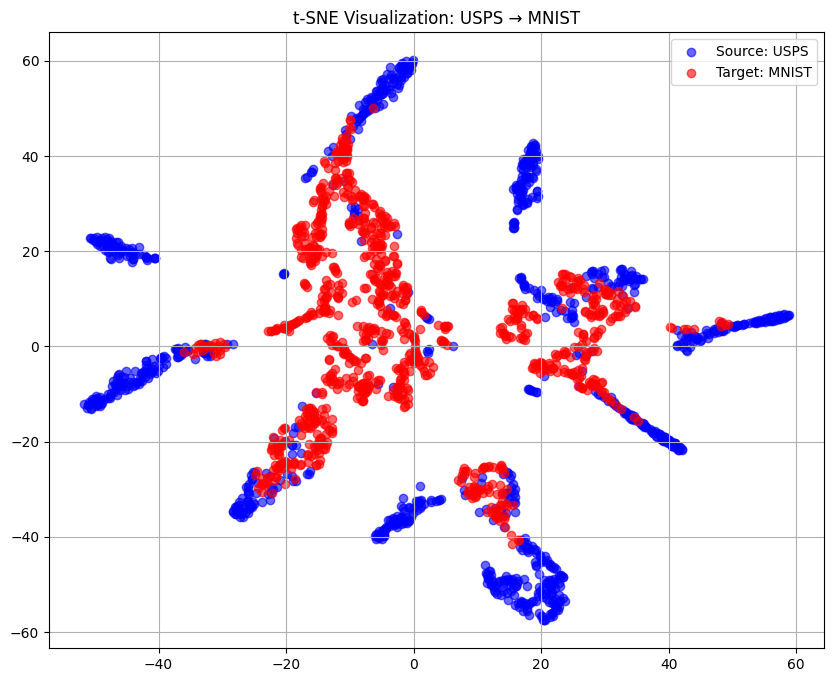

In [89]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="USPS",
        target_name="MNIST"
    )

In [90]:
source_loader, target_loader = load_digits_dataset('USPS', 'SVHN', batch_size=32, subset_size=1000)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
source_accuracy = performance_drop(model, source_loader, device)
target_accuracy = performance_drop(model, target_loader, device)
drop = ((source_accuracy - target_accuracy) / source_accuracy ) * 100

print(f"Source Accuracy: {source_accuracy:.2f}%")
print(f"Target Accuracy: {target_accuracy:.2f}%")
print(f"Performance Drop: {drop:.2f}%")
performance_drops.append(drop)

Using downloaded and verified file: ./data/test_32x32.mat
Source Accuracy: 90.40%
Target Accuracy: 12.80%
Performance Drop: 85.84%


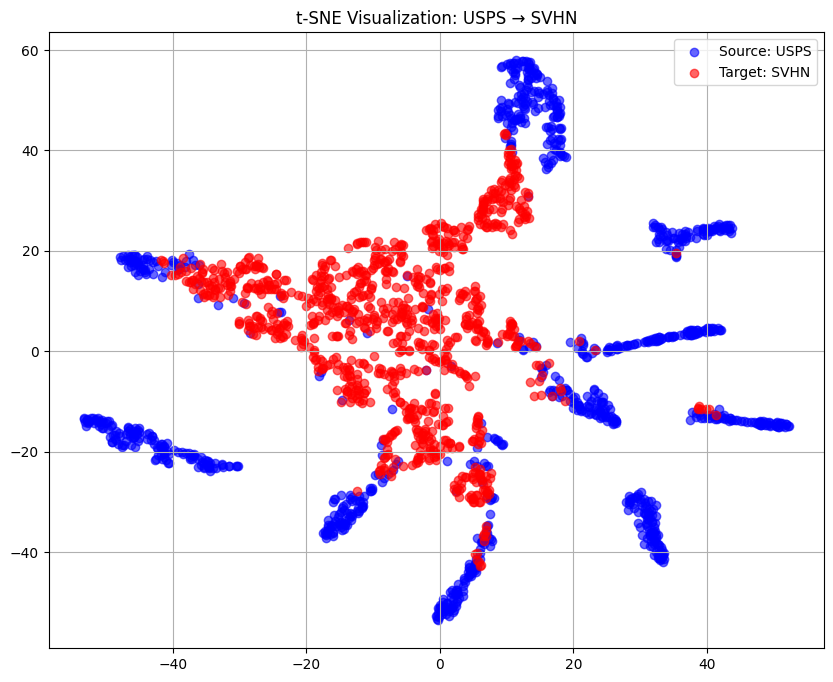

In [91]:
visualize_tsne(
        source_loader=source_loader,
        target_loader=target_loader,
        model=model,
        device=device,
        source_name="USPS",
        target_name="SVHN"
    )

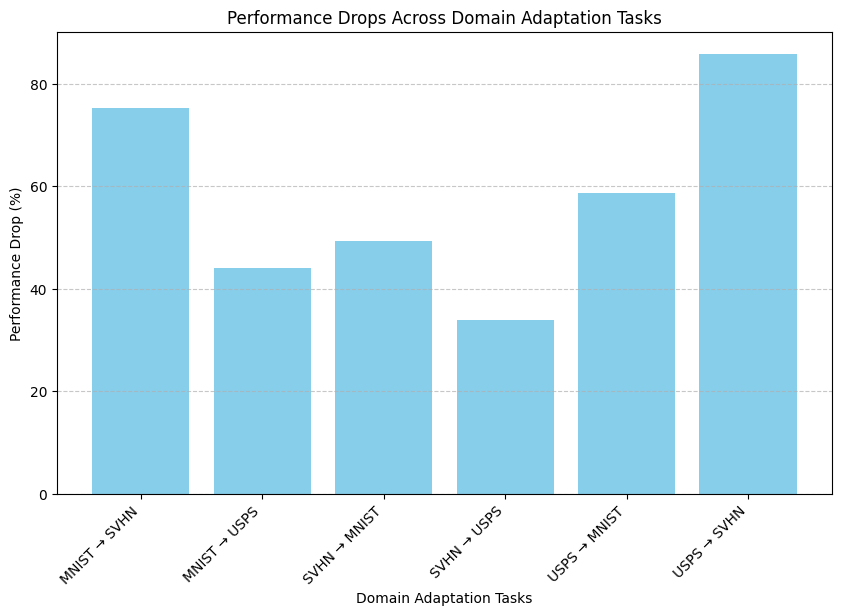

In [92]:
import matplotlib.pyplot as plt

# Define the tasks and their corresponding performance drops
tasks = [
    "MNIST → SVHN",
    "MNIST → USPS",
    "SVHN → MNIST",
    "SVHN → USPS",
    "USPS → MNIST",
    "USPS → SVHN"
]
# performance_drops = [73.07, 37.67, 36.43, 26.25, 33.73, 79.87]

# Plot the performance drops
plt.figure(figsize=(10, 6))
plt.bar(tasks, performance_drops, color='skyblue')
plt.title("Performance Drops Across Domain Adaptation Tasks")
plt.xlabel("Domain Adaptation Tasks")
plt.ylabel("Performance Drop (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()